<a href="https://colab.research.google.com/github/Ved0715/Malaria-Diagnosis/blob/main/with_Sequential_API/Malaria_Diagnosis_Classification_with_Sequential_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<h2>Importing Libraries<h2/>**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , Flatten , InputLayer ,BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

**<h2>Dataset Handling</h2>**

<h3>Data Loading</h3>


In [2]:
dataset , dataset_info = tfds.load('malaria' , with_info = True , as_supervised=True , shuffle_files=True , split =['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteS4RHLL/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpt3cl9mkrtfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [4]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

<h3> Splitting the data into Train , Validation and Test dataset </h3>

In [5]:
def splits (dataset ,TRAIN_RATIO , VAL_RATIO , TEST_RATIO ):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(DATASET_SIZE*TRAIN_RATIO))

  val_dataset = dataset.skip(int(DATASET_SIZE*TRAIN_RATIO))
  val_dataset = val_dataset.take(int(DATASET_SIZE*VAL_RATIO))

  test_dataset = dataset.skip(int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)))

  return train_dataset , val_dataset , test_dataset

In [6]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset , val_dataset , test_dataset = splits(dataset[0] ,TRAIN_RATIO , VAL_RATIO , TEST_RATIO )

print(list(train_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)]


**<h1>Dataset Visualization</h1>**

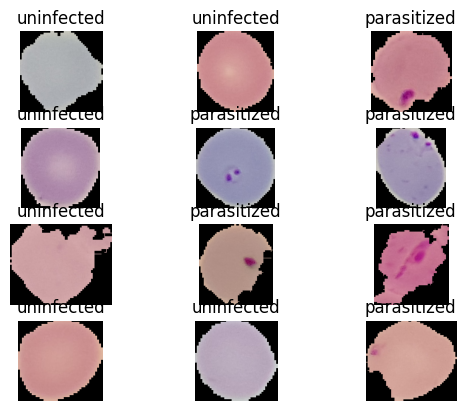

In [7]:
for i , (image , label) , in enumerate(train_dataset.take(12)):
  ax = plt.subplot(4 , 3,i +1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

**<h1>Data Preprocessing</h1>**

1) First making all the images of same size (224 by 224)<br>
2) Using the normilazation technique(max-min mathod(max = 255 and min = 0))<br>

Note:<br>
There is a difference between Standization(mean-stand_deviation method) and Normilazation
  

<h2>Image Resizing</h2>

In [8]:
IM_SIZE = 224
def resize_rescale(image , label):
  return tf.image.resize(image ,(IM_SIZE , IM_SIZE))/255.0  ,  label

In [9]:
train_dataset =  train_dataset.map(resize_rescale)
val_dataset =  val_dataset.map(resize_rescale)
test_dataset =  test_dataset.map(resize_rescale)

In [10]:
for image , label in train_dataset.take(1):
  print(image , label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


Note above the size is changed.<br>
Also the type is changed.


In [11]:
train_dataset = train_dataset.shuffle(buffer_size = 8 , reshuffle_each_iteration = True ).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8 , reshuffle_each_iteration = True ).batch(32).prefetch(tf.data.AUTOTUNE)


**<h1>Model Creation</h1>**


<h3>Note:</h3>
This here (below) is LeNet Articture :<br>
It has high hardware requirements, large training sample size, long training time, slow convergence speed, and low accuracy .

We are going to use even better models.

In [12]:
model = tf.keras.Sequential([
                          InputLayer(input_shape = (IM_SIZE , IM_SIZE , 3)),

                          Conv2D(
                              filters = 6,
                              kernel_size = 3,
                              strides= 1,
                              padding='valid',
                              activation = 'relu'
                          ),
                          BatchNormalization(),

                          MaxPooling2D(
                              pool_size=2,
                              strides=2,

                          ),


                          Conv2D(
                              filters = 16,
                              kernel_size = 3,
                              strides= 1,
                              padding='valid',
                              activation = 'relu'
                          ),
                          BatchNormalization(),
                          MaxPooling2D(
                              pool_size=2,
                              strides=2,

                          ) ,


                          Flatten(),

                          Dense(100, activation = 'relu') ,
                          # Dense(1000, activation = 'sigmoid')
                          BatchNormalization(),

                          Dense(10, activation = 'relu') ,
                          BatchNormalization(),

                          Dense(1, activation = 'sigmoid')






])
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [13]:
model.compile(optimizer = Adam(learning_rate =0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy'
              )

In [14]:
history = model.fit(train_dataset , validation_data = val_dataset , epochs = 50 ,verbose =1)

Epoch 1/50
689/689 [==============================] - 62s 78ms/step - loss: 0.3401 - accuracy: 0.8537 - val_loss: 0.2895 - val_accuracy: 0.9089
Epoch 2/50
689/689 [==============================] - 53s 77ms/step - loss: 0.2109 - accuracy: 0.9265 - val_loss: 0.4554 - val_accuracy: 0.7212
Epoch 3/50
689/689 [==============================] - 47s 69ms/step - loss: 0.1726 - accuracy: 0.9426 - val_loss: 0.6593 - val_accuracy: 0.6606
Epoch 4/50
689/689 [==============================] - 49s 71ms/step - loss: 0.1585 - accuracy: 0.9485 - val_loss: 0.1467 - val_accuracy: 0.9546
Epoch 5/50
689/689 [==============================] - 53s 76ms/step - loss: 0.1534 - accuracy: 0.9487 - val_loss: 0.5008 - val_accuracy: 0.6392
Epoch 6/50
689/689 [==============================] - 48s 70ms/step - loss: 0.1656 - accuracy: 0.9429 - val_loss: 0.2000 - val_accuracy: 0.9372
Epoch 7/50
689/689 [==============================] - 53s 76ms/step - loss: 0.1363 - accuracy: 0.9571 - val_loss: 0.1437 - val_accuracy:

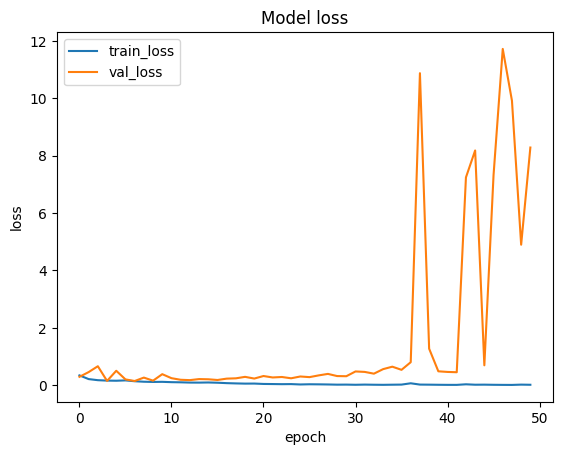

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss' , 'val_loss'])
plt.show()

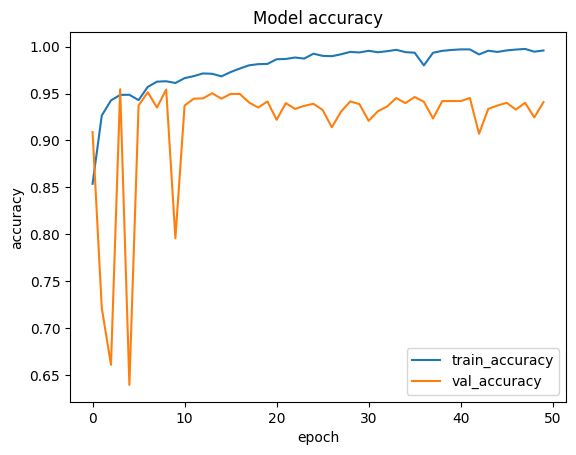

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train_accuracy' , 'val_accuracy'])
plt.show()

**<h1>Model Evaluation and Testing</h1>**

In [17]:
test_dataset = test_dataset.batch(1)

In [19]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [20]:
model.evaluate(test_dataset)

2756/2756 [==============================] - 25s 5ms/step - loss: 0.3661 - accuracy: 0.9325


[0.3660525977611542, 0.9325109124183655]

In [21]:
model.predict(test_dataset.take(1))

1/1 [==============================] - 21s 21s/step


array([[9.079927e-05]], dtype=float32)

In [22]:
def parasite_or_not(x):
  if (x<0.5):
    return str("P")
  else:
    return str("U")

In [23]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 11s 11s/step


'U'

1/1 [==============================] - 0s 18ms/step


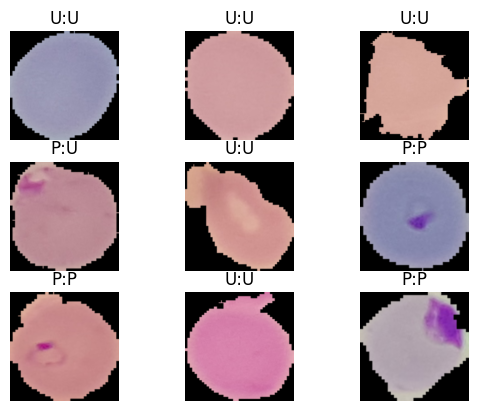

In [24]:
for i , (image , label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3 , 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ':' +str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')